## instalar librerias

In [1]:
!pip install omegaconf==2.1.1

In [1]:
! git clone https://github.com/v-iashin/video_features.git

Cloning into 'video_features'...
remote: Enumerating objects: 1446, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 1446 (delta 306), reused 279 (delta 244), pack-reused 1047 (from 1)
Receiving objects: 100% (1446/1446), 288.83 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (790/790), done.
Updating files: 100% (100/100), done.


## Decargamos los datos

In [ ]:
import kagglehub

path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

 70%|██████▉   | 16.1G/23.1G [13:05<05:09, 24.1MB/s]

## Folder donde se guardaron los datos

In [ ]:
import shutil
import os
import pandas as pd

In [ ]:
path_dataset = os.path.join(path,'fashion-dataset')
path_dataset_images_csv = os.path.join(path,'fashion-dataset','images.csv')
path_dataset_images = os.path.join(path,'fashion-dataset','images')

## Revisamos los datos

In [6]:
list_images = os.listdir(path_dataset_images)
print(len(list_images))

44441


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(list_images)

44441

## Nos movemos al folder del repositorio

In [ ]:
%cd video_features

/content/video_features


## Declaramos RESNET

In [ ]:
from models.resnet.extract_resnet import ExtractResNet
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

'Tesla T4'

## Conectamos con un folder de drive

In [9]:
base_path = '/content/drive/MyDrive'
os.listdir(base_path)

['Colab Notebooks', 'ML_P3_Videos', 'Data_procesada', 'dataset']

## Declaramos el folder para dejar los embeddings

In [10]:
dataset_folder = os.path.join(base_path,"dataset")
dataset_folder_input = os.path.join(dataset_folder, "input")
dataset_folder_output = os.path.join(dataset_folder, "output")


print(dataset_folder)
print(dataset_folder_input)
print(dataset_folder_output)

/content/drive/MyDrive/dataset
/content/drive/MyDrive/dataset/input
/content/drive/MyDrive/dataset/output


## Crear folders

In [ ]:
if not os.path.exists(dataset_folder):
  os.makedirs(dataset_folder, exist_ok=True)
if not os.path.exists(dataset_folder_input):
  os.makedirs(dataset_folder_input, exist_ok=True)
if not os.path.exists(dataset_folder_output):
  os.makedirs(dataset_folder_output, exist_ok=True)

## Configuramos la extracción de características


In [ ]:
path_list_images = [os.path.join(path_dataset_images, image_name) for image_name in list_images]

# Select the feature type
feature_type = 'resnet'
model_name = 'resnet152'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.feature_type = feature_type
args.model_name = model_name
args.video_paths = path_list_images
args.batch_size = 32
# args.extraction_fps = 1
# args.show_pred = True

extractor = ExtractResNet(args)


## Declaramos el archivo de embeddings

In [ ]:
save_path = os.path.join(dataset_folder_output, 'v_temp.pkl')

## Generamos los embeddings

In [ ]:
features_list = []
current_image = 0
for video_path in args.video_paths:

#--------------------- Guardamos cada 500 embeddings creados --------------------#
  if len(features_list) % 500 == 0:
    current_image += len(features_list)
    with open(save_path + "_"+ str(current_image), 'wb') as f:
      pickle.dump(features_list, f)
    features_list = []

  feature_dict = extractor.extract(video_path)
  features_list.append({
      'image_name':video_path.split('/')[-1],
      'embedding': feature_dict['resnet']
  })
#--------------------- Guardamos cada los últimos embeddings --------------------#
current_image += len(features_list)
with open(save_path + "_"+ str(current_image), 'wb') as f:
  pickle.dump(features_list, f)


## Cargar embeddings ya creados

In [26]:
import pickle
path_files = ['the_last_one.pkl']
dict_features = []
for path in path_files:
  with open(os.path.join(dataset_folder, path), 'rb') as f:
    data_loaded = pickle.load(f)
    dict_features = dict_features + data_loaded

## Revisamos nombres

In [30]:
list_image_names = [feature['image_name'] for feature in dict_features]
reps = pd.Series(list_image_names).value_counts()
reps_2 = reps[reps > 1]
len(dict_features)
len(dict_features)
print(len(reps))
print(len(reps_2))

## Revisamos duplicados

In [50]:
list_image_shapes = [{'shape':feature['embedding'].shape, 'image_name': feature['image_name']} for feature in dict_features]
reps = pd.DataFrame(list_image_shapes)['shape'].value_counts()
reps_2 = reps[reps > 1]
len(dict_features)
print(len(reps))
print(len(reps_2))

2
2


## Mapeamos duplicados

In [52]:
shapes_images = pd.DataFrame(list_image_shapes)
reps_shapes_images = shapes_images[shapes_images['shape'] == (0,)]
reps_shapes_images_idx = reps_shapes_images.index

In [55]:
shapes_images_vacio = shapes_images.iloc[reps_shapes_images_idx]
shapes_images_vacio

,shape,image_name
6697,"(0,)",39403.jpg
16207,"(0,)",39410.jpg
32324,"(0,)",39401.jpg
36399,"(0,)",39425.jpg
40022,"(0,)",12347.jpg


## Filtramos embeddings vacios

In [56]:
image_names_vacio = shapes_images_vacio['image_name'].tolist()
list_images = [feature for feature in dict_features if not feature['image_name'] in image_names_vacio]

### Nota: Los embeddings vacios resultan porque en el folder de imagenes de kaggle solo hay 44441 imagenes, pero en el csv de imagenes hay 44446, entonces son 5 imágenes sin información y sale vacios.

In [57]:
len(list_images)

44441

Guardamos los embeddings

In [59]:
import pickle
with open(os.path.join(dataset_folder, "embeddings.pkl"), 'wb') as f:
  pickle.dump(list_images, f)

## Muestreo de imágenes

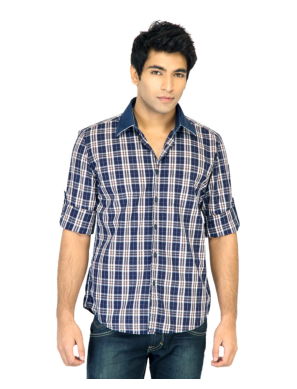

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Cargar la imagen
image = Image.open(images['image_path'].tolist()[0])

# Mostrar la imagen
plt.imshow(image)
plt.axis('off')  # Ocultar ejes (opcional)
plt.show()
